In [1]:
import numpy as np
import pandas as pd
import json
from epilepsypcm.utils.outcome_params import node_location, early_propogation, irritative_zone

import warnings
warnings.filterwarnings("ignore")

from epilepsypcm.utils.make_df import make_df, get_df_list, concat_dfs
from epilepsypcm.models.base_models import *
from sklearn.metrics import auc

all_positive_patients = pd.read_csv("df_final.csv", sep = ',').reset_index(drop = True)

print(all_positive_patients["outcome"].value_counts())


0.0    259
1.0     56
Name: outcome, dtype: int64


In [2]:
# Number of positive samples per patient in the data

print(all_positive_patients[all_positive_patients["outcome"] == 1.0]["patient"].value_counts())
all_positive_patients.head()

PY21N004    10
PY21N008     8
PY19N026     8
PY19N023     5
PY18N015     5
PY18N002     5
PY18N016     4
PY20N001     3
PY16N008     3
PY19N009     2
PY19N012     2
PY17N005     1
Name: patient, dtype: int64


,Unnamed: 0,Channels,outcome,IZ,EP,SigResp,SigStim,N1RespAvg,N1RespSDV,N2RespAvg,...,N1StimSDV,N2StimAvg,N2StimSDV,P2StimAvg,P2StimSDV,patient,InDegree,OutDegree,EV,Closeness
0,0,LA1_LA2,1.0,0.0,0.0,0.000000,0.064516,0.000000,0.000000,0.000000,...,2.011706,3.724259,3.460362,2.796966,3.000218,PY21N008,0.000000,0.071429,4.993936e-14,0.000000
1,1,LA9_LA10,0.0,1.0,0.0,0.000000,0.193548,1.808045,1.676081,2.493333,...,9.957544,5.060794,6.246739,4.478926,6.889325,PY21N008,0.000000,0.214286,4.993936e-14,0.000000
2,2,LAH1_LAH2,1.0,1.0,0.0,0.064516,0.193548,7.116911,19.154270,4.252294,...,14.745868,3.809967,3.367630,1.821021,1.867067,PY21N008,0.071429,0.214286,7.960633e-04,0.174603
3,3,LAH8_LAH9,0.0,0.0,0.0,0.290323,0.096774,4.306443,3.856300,4.059026,...,2.173960,1.695722,1.598789,1.574253,2.044144,PY21N008,0.321429,0.107143,1.590588e-01,0.480159
4,4,LPH1_LPH2,0.0,1.0,0.0,0.096774,0.258065,5.792531,15.863221,3.143365,...,7.764073,3.585250,3.693649,3.242192,3.639533,PY21N008,0.107143,0.285714,4.743272e-03,0.218807


# Random Forest Model

In [3]:
plot_roc = False
plot_pr = False

X_list = ["Channels", "SigResp", "N1RespAvg", "N1RespSDV", "N2RespAvg", "N2RespSDV", "P2RespAvg", "P2RespSDV", 
          "SigStim", "N1StimAvg", "N1StimSDV", "N2StimAvg", "N2StimSDV", "P2StimAvg", "P2StimSDV",
         "InDegree", "OutDegree", "EV", "Closeness"]

smote = False
max_depth = 100
rf, test_channels, y_pred, y_test, tpr, fpr, roc_thresholds, precision, recall = random_forest(all_positive_patients, X_list, max_depth, plot_roc, plot_pr, smote)

#getting model and stats
from sklearn.metrics import confusion_matrix

# Printing Metrics
optimal_thresh = roc_thresholds[np.argmax(tpr - fpr)]
print("Optimal roc threshold: ", optimal_thresh)
y_rounded = np.where(y_pred > optimal_thresh, 1, 0)

tn, fp, fn, tp = confusion_matrix(y_test, y_rounded).ravel()

print("Accuracy: ", (tp + tn)/(tp + fp + tn + fn))
print("Sensitivity: ", tp / (tp + fn))
print("Specificity: ", tn / (tn + fp))

Optimal roc threshold:  0.22
Accuracy:  0.7848101265822784
Sensitivity:  0.9285714285714286
Specificity:  0.7538461538461538


<AxesSubplot:>

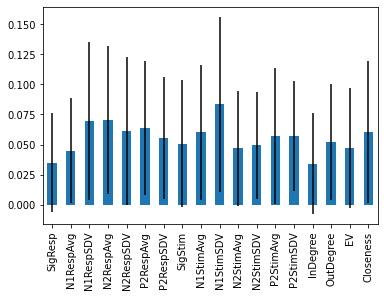

In [4]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)


forest_importances = pd.Series(importances, index=X_list[1:])

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)

In [5]:
# saving model
#import pickle

#filename = 'final_random_forest.sav'
#pickle.dump(rf, open(filename, 'wb'))

## Boxplots - standard

In [6]:
# getting labels for the boxplot

epilepsy_normal = []
channels_normal = []
correct_normal = []

non_epilepsy = []
channels_non = []
correct_non = []

i = 0
while i < len(y_test):
    if list(y_test)[i] == 1.0:
        epilepsy_normal.append(y_pred[i])
        channels_normal.append(test_channels[i])
        
        if y_pred[i] > optimal_thresh: #seeing if prediction was correct for true positives
            
            no_digits = ''.join(i for i in test_channels[i] if not i.isdigit()) #dropping digits from channel name
            channel_split = no_digits.split("_")
            for key in node_location.keys():
                if (channel_split[0] == key) | (channel_split[1] == key): # if channel matches node label, label it
                    label = node_location[key]
            correct_normal.append("Correctly labeled - " + label)
            
        elif y_pred[i] <= optimal_thresh:
            
            no_digits = ''.join(i for i in test_channels[i] if not i.isdigit()) #dropping digits from channel name
            channel_split = no_digits.split("_")
            for key in node_location.keys():
                if (channel_split[0] == key) | (channel_split[1] == key): # if channel matches node label, label it
                    label = node_location[key]
            correct_normal.append("Mislabeled - " + label)
            
    elif list(y_test)[i] == 0.0:
        non_epilepsy.append(y_pred[i])
        channels_non.append(test_channels[i])
        
        if y_pred[i] < optimal_thresh: #seeing if prediction was correct for true negatives
            
            no_digits = ''.join(i for i in test_channels[i] if not i.isdigit()) #dropping digits from channel name
            channel_split = no_digits.split("_")
            for key in node_location.keys():
                if (channel_split[0] == key) | (channel_split[1] == key): # if channel matches node label, label it
                    label = node_location[key]
            correct_non.append("Correctly labeled - " + label)            
            
        elif y_pred[i] >= optimal_thresh:
            
            no_digits = ''.join(i for i in test_channels[i] if not i.isdigit()) #dropping digits from channel name
            channel_split = no_digits.split("_")
            for key in node_location.keys():
                if (channel_split[0] == key) | (channel_split[1] == key): # if channel matches node label, label it
                    label = node_location[key]
            correct_non.append("Mislabeled - " + label)    
    
    i += 1
    
correct_normal_ordered = [x for _,x in sorted(zip(epilepsy_normal, correct_normal), reverse = True)]
correct_non_ordered = [x for _,x in sorted(zip(non_epilepsy, correct_non), reverse = True)]
            
print("\n")
print("Positive labels")            
print(*correct_normal_ordered, sep = "\n")

print("\n")
print("Negative labels")
print(*correct_non_ordered, sep = "\n")



Positive labels
Correctly labeled - Left fronto-temporal grid
Correctly labeled - Left fronto-temporal grid
Correctly labeled - Left fronto-temporal grid
Correctly labeled - left anterior hippocampus
Correctly labeled - Right anterior temporal inferior
Correctly labeled - Right amygdala
Correctly labeled - left amygdala
Correctly labeled - right posterior hippocampus
Correctly labeled - Right amygdala depth
Correctly labeled - Basal temporal anterior
Correctly labeled - Right medial tumor inferior
Correctly labeled - Right anterior hippocampus
Correctly labeled - Left orbitofrontal depth
Mislabeled - left amygdala


Negative labels
Mislabeled - Right amygdala
Mislabeled - left anterior cortical dysplasia
Mislabeled - Basal temporal posterior-temporal
Mislabeled - Left fronto-temporal grid
Mislabeled - Left nodule E
Mislabeled - Left fronto-temporal grid
Mislabeled - Basal temporal mid-temporal
Mislabeled - Left sensory area
Mislabeled - Left temporal grid
Mislabeled - right posterior

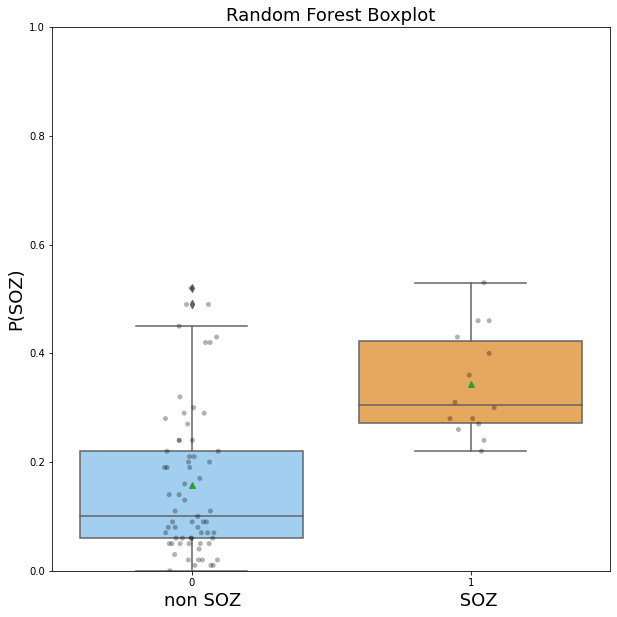

In [8]:
# Plotting boxplot
import seaborn as sns

plt.figure(figsize = (10,10))
plt.title("Random Forest Boxplot", fontsize = 18)
plt.xlabel("non SOZ                                      SOZ", fontsize = 18)
plt.ylabel("P(SOZ)", fontsize = 18)
plt.ylim([0,1])

sns.boxplot(
    data=[non_epilepsy, epilepsy_normal],
    palette=[sns.xkcd_rgb["light blue"], sns.xkcd_rgb["light orange"]],
    showmeans=True,
)

sns.stripplot(
    color = 'black',
    alpha = 0.3, 
    data=[non_epilepsy, epilepsy_normal],
)

plt.savefig("RF_Boxplot.pdf")

## Boxplots - including Irritative Zone and Early Propogation Zone Labels

In [265]:
# getting labels with IZ and EP

epilepsy_normal = []
channels_normal = []
correct_normal = []

non_epilepsy = []
channels_non = []
correct_non = []

iz = all_positive_patients["IZ"]
ep = all_positive_patients["EP"]

i = 0
while i < len(y_test):
    if list(y_test)[i] == 1.0:
        epilepsy_normal.append(y_pred[i])
        channels_normal.append(test_channels[i])
        
        if y_pred[i] > optimal_thresh: #seeing if prediction was correct for true positives
            
            no_digits = ''.join(i for i in test_channels[i] if not i.isdigit()) #dropping digits from channel name
            channel_split = no_digits.split("_")
            for key in node_location.keys():
                if (channel_split[0] == key) | (channel_split[1] == key): # if channel matches node label, label it
                    label = node_location[key]
            if iz[y_test.index[i]] == 1.0:
                correct_normal.append("Correctly labeled, IZ - " + label)
            elif ep[y_test.index[i]] == 1.0:
                correct_normal.append("Correctly labeled, EP - " + label)
            elif ((iz[y_test.index[i]] == 1.0) & (ep[y_test.index[i]] == 1.0)):
                correct_normal.append("Correctly labeled, IZ & EP - " + label)                
            else:
                correct_normal.append("Correctly labeled - " + label)
            
        elif y_pred[i] <= optimal_thresh:
            
            no_digits = ''.join(i for i in test_channels[i] if not i.isdigit()) #dropping digits from channel name
            channel_split = no_digits.split("_")
            for key in node_location.keys():
                if (channel_split[0] == key) | (channel_split[1] == key): # if channel matches node label, label it
                    label = node_location[key]
            if iz[y_test.index[i]] == 1.0:
                correct_normal.append("Mislabeled, IZ - " + label)
            elif ep[y_test.index[i]] == 1.0:
                correct_normal.append("Mislabeled, EP - " + label)
            elif ((iz[y_test.index[i]] == 1.0) & (ep[y_test.index[i]] == 1.0)):
                correct_normal.append("Mislabeled, IZ & EP - " + label)                
            else:
                correct_normal.append("Mislabeled - " + label)
                
    elif list(y_test)[i] == 0.0:
        non_epilepsy.append(y_pred[i])
        channels_non.append(test_channels[i])
        
        if y_pred[i] < optimal_thresh: #seeing if prediction was correct for true negatives
            
            no_digits = ''.join(i for i in test_channels[i] if not i.isdigit()) #dropping digits from channel name
            channel_split = no_digits.split("_")
            for key in node_location.keys():
                if (channel_split[0] == key) | (channel_split[1] == key): # if channel matches node label, label it
                    label = node_location[key]
            if iz[y_test.index[i]] == 1.0:
                correct_non.append("Correctly labeled, IZ - " + label)
            elif ep[y_test.index[i]] == 1.0:
                correct_non.append("Correctly labeled, EP - " + label)
            elif ((iz[y_test.index[i]] == 1.0) & (ep[y_test.index[i]] == 1.0)):
                correct_non.append("Correctly labeled, IZ & EP - " + label)                
            else:
                correct_non.append("Correctly labeled - " + label)
                
        elif y_pred[i] >= optimal_thresh:
            
            no_digits = ''.join(i for i in test_channels[i] if not i.isdigit()) #dropping digits from channel name
            channel_split = no_digits.split("_")
            for key in node_location.keys():
                if (channel_split[0] == key) | (channel_split[1] == key): # if channel matches node label, label it
                    label = node_location[key]
            if iz[y_test.index[i]] == 1.0:
                correct_non.append("Mislabeled, IZ - " + label)
            elif ep[y_test.index[i]] == 1.0:
                correct_non.append("Mislabeled, EP - " + label)
            elif ((iz[y_test.index[i]] == 1.0) & (ep[y_test.index[i]] == 1.0)):
                correct_non.append("Mislabeled, IZ & EP - " + label)                
            else:
                correct_non.append("Mislabeled - " + label)    
    i += 1
    
correct_normal_ordered = [x for _,x in sorted(zip(epilepsy_normal, correct_normal), reverse = True)]
correct_non_ordered = [x for _,x in sorted(zip(non_epilepsy, correct_non), reverse = True)]
            
print("\n")
print("Positive labels")            
print(*correct_normal_ordered, sep = "\n")

print("\n")
print("Negative labels")
print(*correct_non_ordered, sep = "\n")



Positive labels
Correctly labeled - Left fronto-temporal grid
Correctly labeled, IZ - Left fronto-temporal grid
Correctly labeled, IZ - Left fronto-temporal grid
Correctly labeled, IZ - left anterior hippocampus
Correctly labeled - Right anterior temporal inferior
Correctly labeled - Right amygdala
Correctly labeled - left amygdala
Correctly labeled, IZ - right posterior hippocampus
Correctly labeled, IZ - Basal temporal anterior
Correctly labeled - Right amygdala depth
Correctly labeled - Right medial tumor inferior
Correctly labeled, IZ - Right anterior hippocampus
Correctly labeled - Left orbitofrontal depth
Mislabeled, IZ - left amygdala


Negative labels
Mislabeled - Right amygdala
Mislabeled, IZ - left anterior cortical dysplasia
Mislabeled - Basal temporal posterior-temporal
Mislabeled - Left fronto-temporal grid
Mislabeled - Left nodule E
Mislabeled - Left fronto-temporal grid
Mislabeled - Basal temporal mid-temporal
Mislabeled - Left sensory area
Mislabeled - Left temporal g

## Feature Importances

Most Significant Feature:  N1StimSDV
Least Significant Feature:  InDegree


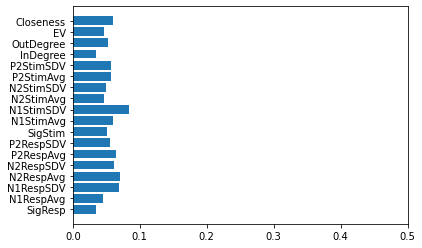

In [266]:
# feature importances

X_list = ["Channels", "SigResp", "N1RespAvg", "N1RespSDV", "N2RespAvg", "N2RespSDV", "P2RespAvg", "P2RespSDV", 
          "SigStim", "N1StimAvg", "N1StimSDV", "N2StimAvg", "N2StimSDV", "P2StimAvg", "P2StimSDV",
         "InDegree", "OutDegree", "EV", "Closeness"]

#random forest + network features
smote = False
max_depth = 20
rf, y_pred, test_channels, y_test, tpr, fpr, roc_thresholds, precision, recall = random_forest(all_positive_patients, X_list, max_depth, plot_roc, plot_pr, smote)

#rf.feature_importances_

plt.barh(X_list[1:], rf.feature_importances_)
plt.xlim([0,.5])
print("Most Significant Feature: ", X_list[1:][list(rf.feature_importances_).index(max(rf.feature_importances_))])
print("Least Significant Feature: ", X_list[1:][list(rf.feature_importances_).index(min(rf.feature_importances_))])